## Transpilation & Pass Managers

In order to transpile our circuits, we must use pass managers (account needed)

### What is a Pass Manager?

A pass manager manages the transpilation process, which decomposes a high-level quantum circuit into something executable on a certain hardware confined to a certain ISA (Instruction Set Architecture).

Each individual step of transpilation is called a 'pass'; ex. consolidating all consecutive single qubit gate would be one pass. A 'pass manager' literally manages these steps. Which steps do we do and in what order?

In [2]:
# Note: Make sure you have saved your IBM Quantum account previously (ibm_account.ipynb -- but with your token)
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

# get available backends
print(service.backends())

# Determine basis gates for ibm_fez backend (translation stage)
backend = service.backend("ibm_fez", instance=None, use_fractional_gates=False)
print(backend.operation_names)

[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_torino')>]
['cz', 'rz', 'reset', 'delay', 'id', 'sx', 'measure', 'x', 'if_else']


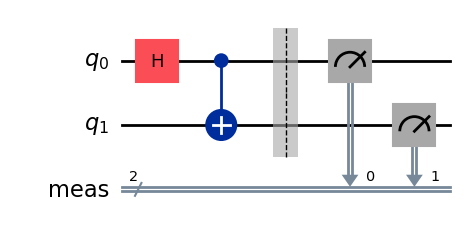

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)
qc.measure_all()

qc.draw('mpl')

### Preset Pass Manager

A preset pass manager allows us to pass a specific backend, and it will do all of the work for us to be executable on that backend

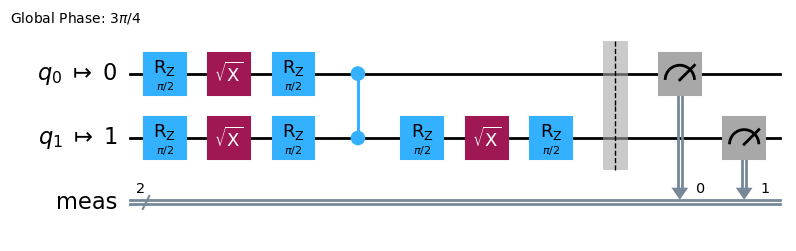

In [ ]:
# Let's transpile this circuit to be able to run on hardware (using basis gates of ibm_fez)
from qiskit.transpiler import generate_preset_pass_manager

# genereate_preset_pass_manager parameters: 
#   optimization_level=0-3 (higher = more optimization, longer transpile time), backend=backend
#   backend: auto-determines the other optional parameters such as coupling_map, basis_gates, etc.
#   coupling_map: tells which physical qubits can directly interact on the hardware
#   basis_gates: basis gates to transpile to
#   dt: backend sample time
#   initial_layout: intial mapping of virtual to physical qubits
#   *_method: which method to use for various stages of the transpilation process
pass_manager = generate_preset_pass_manager(optimization_level=0, backend=backend)

transpiled_circuit = pass_manager.run(qc)
transpiled_circuit.draw('mpl')

Already, we can see differences between optimizer levels

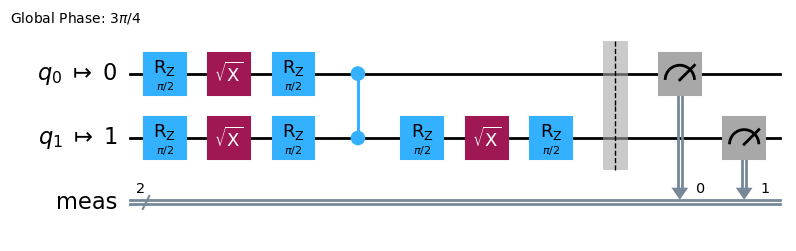

In [12]:
# Optimization level 1
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

transpiled_circuit = pass_manager.run(qc)
transpiled_circuit.draw('mpl')

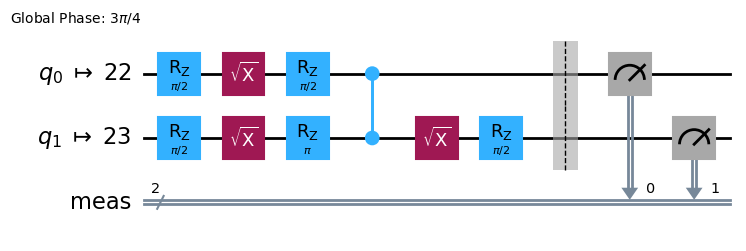

In [13]:
#Optimization Level 2
pass_manager = generate_preset_pass_manager(optimization_level=2, backend=backend)

transpiled_circuit = pass_manager.run(qc)
transpiled_circuit.draw('mpl')

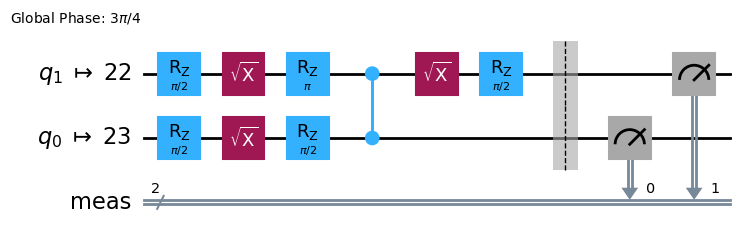

In [14]:
#Optimization Level 3
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

transpiled_circuit = pass_manager.run(qc)
transpiled_circuit.draw('mpl')

Let's explore the other parameters as well

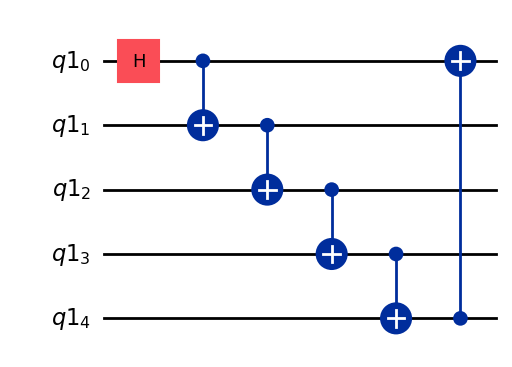

In [26]:
from qiskit.circuit import QuantumRegister

# GHZ State
size = 5

qubits = QuantumRegister(size)

ghz = QuantumCircuit(qubits)

ghz.h(0)

for i in range(size):
    j = (i + 1) % size
    
    ghz.cx(i,j)

ghz.draw('mpl')

C:\Users\antho\AppData\Local\Temp\ipykernel_30496\4193210152.py:9: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(optimization_level=0, coupling_map=coupling_map, initial_layout=initial_layout, backend=backend)


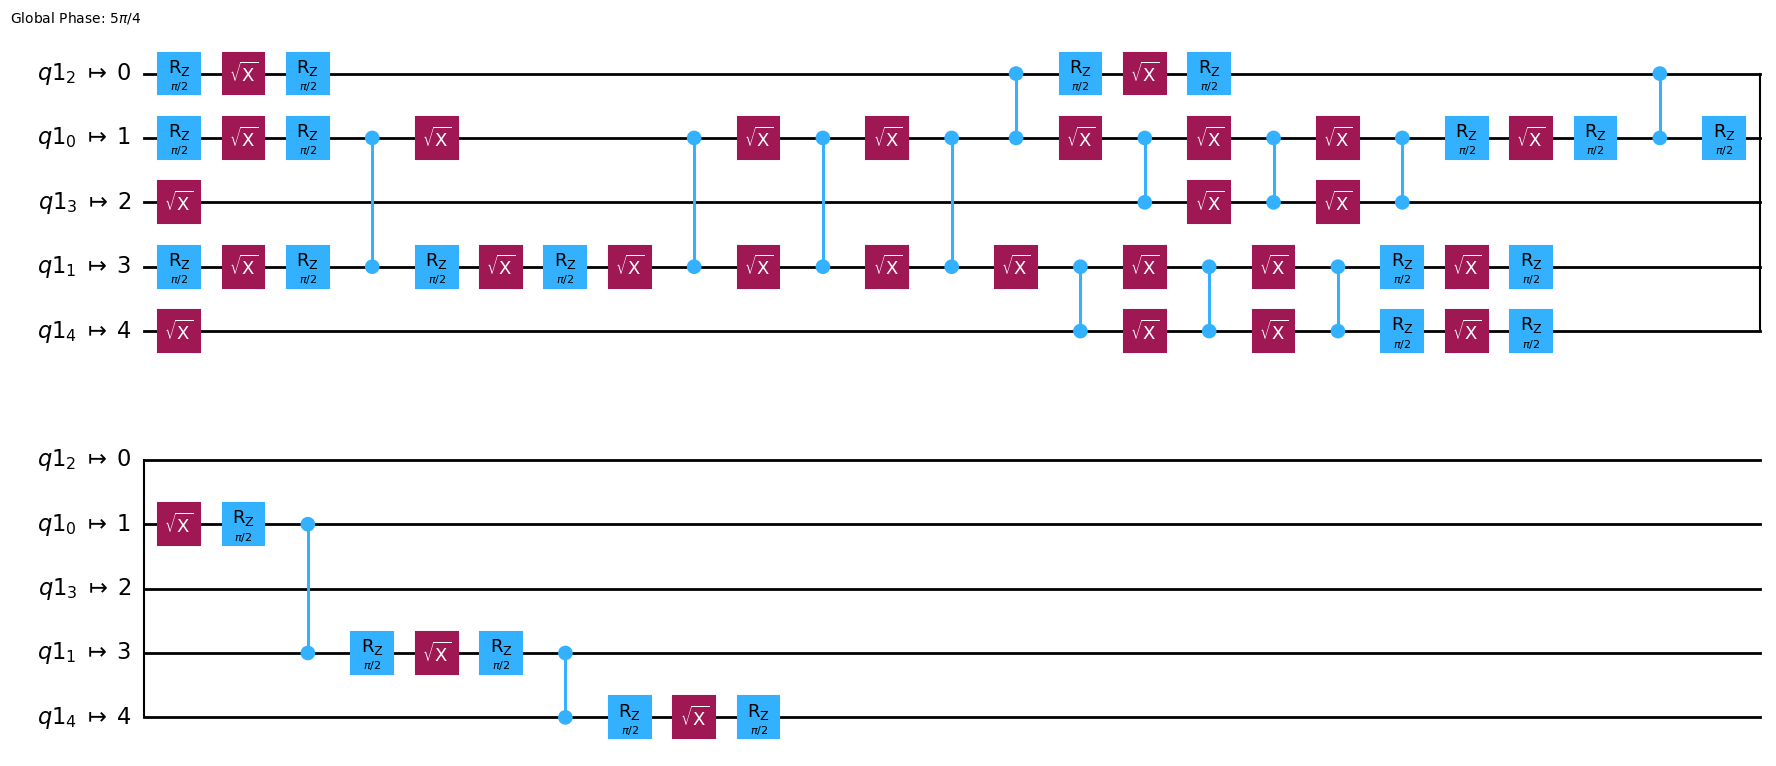

In [30]:
from qiskit.transpiler import CouplingMap, Layout

(q0, q1, q2, q3, q4) = qubits

coupling_map = CouplingMap([[0, 1], [1, 2], [1, 3], [3, 4]])

initial_layout = Layout({q0: 1, q1: 3, q2: 0, q3: 2, q4: 4})

pass_manager = generate_preset_pass_manager(optimization_level=0, coupling_map=coupling_map, initial_layout=initial_layout, backend=backend)

transpiled_circuit = pass_manager.run(ghz)
transpiled_circuit.draw('mpl')

### Customized Pass Managers
Preset pass managers are great, but what if we wanted to use a non-IBM computer or see if a certain circuit can theoretically be decomposed into a small number of basis gates? That's where customized pass managers come in

In [ ]:
# Generalized, custom pass managers can also be created (preset pass managers are convenient shortcuts for a specific hardware)
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Collect2qBlocks,ConsolidateBlocks, UnitarySynthesis # these are example passes
 
basis_gates = ["rx", "ry", "rxx"] # Can choose your own basis gates
custom_pm = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

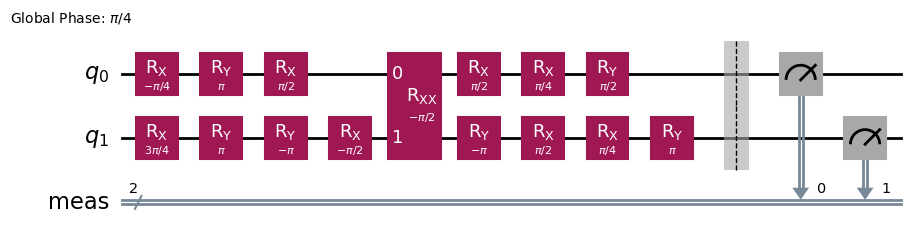

In [16]:
custom_qc = custom_pm.run(qc)
custom_qc.draw('mpl')

### Staged Pass Managers

A staged pass manager is simply a collection of different pass managers, one applied after the other. There is no limit to the number of stages you can have in a staged pass manager (I guess until you run out of memory?...)

In [ ]:
from qiskit.transpiler import StagedPassManager
from qiskit.transpiler.passes import SetLayout, FullAncillaAllocation, EnlargeWithAncilla, ApplyLayout, SabreSwap, BasisTranslator

# This example is trying to visualize the routing from our GHZ example earlier

basis_gates = ['h', 'cx']
layout_pm = PassManager([
    SetLayout(initial_layout),
    FullAncillaAllocation(coupling_map),
    EnlargeWithAncilla(),
    ApplyLayout()
])

# Stage B: Routing (Inserting SWAPs to fit the coupling map)
routing_pm = PassManager([
    SabreSwap(coupling_map, heuristic='decay')
])

# Normally you would put translation stage here but we want to keep our basis for the visualization

# 4. Combine into a StagedPassManager
custom_staged_pm = StagedPassManager(
    stages=['init', 'layout', 'routing'],
    layout=layout_pm,
    routing=routing_pm
)

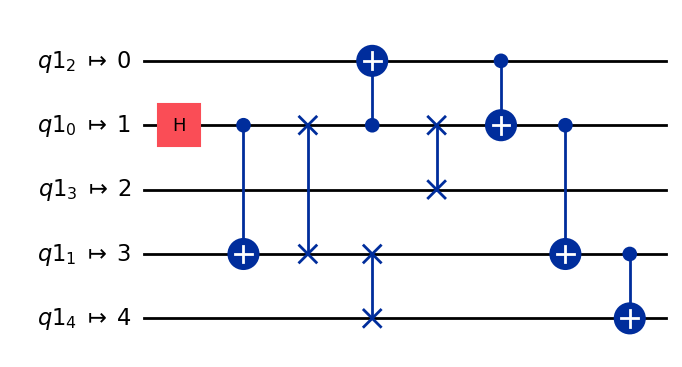

In [34]:
staged_ghz = custom_staged_pm.run(ghz)
staged_ghz.draw('mpl')